In [ ]:
pip install deepxde


In [ ]:
import numpy as np
import os
os.environ["DDEBACKEND"] = "pytorch"
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
import deepxde as dde
from shapely.geometry import Point
import cartopy.feature as cfeature
def save_model(model, path):
    torch.save(model.state_dict(), path)
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# Load and preprocess data
def load_and_preprocess_data():
    print("Starting data load and preprocessing...")
    zarr_ds = xr.open_zarr(store='../shared/data/IO.zarr', consolidated=True)
    zarr_ds = zarr_ds.sel(lat=slice(32, -11.75), lon=slice(42, 101.75))

    all_nan_dates = np.isnan(zarr_ds["CHL_cmes-level3"]).all(dim=["lon", "lat"]).compute()
    zarr_ds = zarr_ds.sel(time=~all_nan_dates)
    zarr_ds = zarr_ds.sortby('time')
    zarr_ds = zarr_ds.sel(time=slice('2019-01-01', '2022-12-31'))
    return zarr_ds

zarr_ds = load_and_preprocess_data()

# Prepare data for PINN
def prepare_data_for_pinn(zarr_ds):
    print("Starting data preparation for PINN...")
    variables = ['CHL_cmes-level3', 'air_temp', 'sst', 'curr_dir', 'ug_curr', 'u_wind', 'v_wind', 'v_curr']
    data = {var: zarr_ds[var].values for var in variables}
    
    water_mask = ~np.isnan(data['sst'][0])
    
    for var in variables:
        data[var] = data[var][:, water_mask]
        data[var] = np.nan_to_num(data[var], nan=np.nanmean(data[var]), posinf=np.nanmax(data[var]), neginf=np.nanmin(data[var]))
        if (var == 'CHL_cmes-level3'):
            data[var] = np.log(data[var])  # Use log CHL
        mean = np.mean(data[var])
        std = np.std(data[var])
        data[var] = (data[var] - mean) / std
        data[f'{var}_mean'] = mean
        data[f'{var}_std'] = std

    time = zarr_ds.time.values
    lat = zarr_ds.lat.values
    lon = zarr_ds.lon.values
    time_numeric = (time - time[0]).astype('timedelta64[D]').astype(float)
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    lat_flat = lat_grid.flatten()[water_mask.flatten()]
    lon_flat = lon_grid.flatten()[water_mask.flatten()]
    
    return data, time_numeric, lat_flat, lon_flat, water_mask

data, time, lat, lon, water_mask = prepare_data_for_pinn(zarr_ds)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define the UNet model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

# Train the UNet model
def train_unet(data, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    features = ['u_wind', 'v_wind', 'sst', 'air_temp']
    X = np.stack([data[feature] for feature in features], axis=1)
    y = data['CHL_cmes-level3']

    # Debug: Print the shapes of X and y before reshaping
    print(f"Original X shape: {X.shape}")
    print(f"Original y shape: {y.shape}")

    num_elements = X.shape[2]
    nearest_square = int(np.floor(np.sqrt(num_elements))**2)
    height = int(np.sqrt(nearest_square))
    width = height

    # Trim X and y to the nearest perfect square
    X = X[:, :, :nearest_square]
    y = y[:, :nearest_square]

    # Reshape X and y to match the expected input shape for UNet
    num_samples = X.shape[0]
    num_features = len(features)

    X = X.reshape(num_samples, num_features, height, width)
    y = y.reshape(num_samples, 1, height, width)

    # Debug: Print the shapes of X and y after reshaping
    print(f"Reshaped X shape: {X.shape}")
    print(f"Reshaped y shape: {y.shape}")

    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).to(device)

    generator = torch.Generator(device=device)
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)

    for epoch in range(epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            # Resize the outputs to match the target size
            outputs = nn.functional.interpolate(outputs, size=(height, width), mode='bilinear', align_corners=False)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
    save_model(model, 'unet_model.pth')
    return model

# Assuming `data` is already loaded and preprocessed
model = UNet()

# Load the model parameters
model = load_model(model, 'unet_model.pth')
# Use the trained UNet model to predict chlorophyll
def predict_chlorophyll(unet_model, data, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    features = ['u_wind', 'v_wind', 'sst', 'air_temp']
    X = np.stack([data[feature] for feature in features], axis=1)

    num_elements = X.shape[2]
    nearest_square = int(np.floor(np.sqrt(num_elements))**2)
    height = int(np.sqrt(nearest_square))
    width = height

    # Trim X to the nearest perfect square
    X = X[:, :, :nearest_square]

    # Reshape X to match the expected input shape for UNet
    num_samples = X.shape[0]
    num_features = len(features)

    X = X.reshape(num_samples, num_features, height, width)

    X = torch.tensor(X, dtype=torch.float32).to(device)

    predictions = []
    unet_model.eval()
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch_X = X[i:i+batch_size]
            batch_predictions = unet_model(batch_X).cpu().numpy()
            predictions.append(batch_predictions)
    predictions = np.concatenate(predictions, axis=0)
    return predictions

chlorophyll_predictions = predict_chlorophyll(unet_model, data)

# Define the PDE for PINN
def pde(x, y):
    lat, lon, t = x[:, 0:1], x[:, 1:2], x[:, 2:3]
    U = y
    dU_dt = dde.grad.jacobian(y, x, i=0, j=2)
    d2U_dlat2 = dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2U_dlon2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2U_dt2 = dde.grad.hessian(y, x, component=0, i=2, j=2)
    
    # Convert numpy arrays to PyTorch tensors
    air_temp = torch.tensor(data['air_temp'], dtype=torch.float32)
    sst = torch.tensor(data['sst'], dtype=torch.float32)
    curr_dir = torch.tensor(data['curr_dir'], dtype=torch.float32)
    ug_curr = torch.tensor(data['ug_curr'], dtype=torch.float32)
    u_wind = torch.tensor(data['u_wind'], dtype=torch.float32)
    v_wind = torch.tensor(data['v_wind'], dtype=torch.float32)
    v_curr = torch.tensor(data['v_curr'], dtype=torch.float32)
    
    # Calculate means
    air_temp_mean = torch.mean(air_temp)
    sst_mean = torch.mean(sst)
    curr_dir_mean = torch.mean(curr_dir)
    ug_curr_mean = torch.mean(ug_curr)
    u_wind_mean = torch.mean(u_wind)
    v_wind_mean = torch.mean(v_wind)
    v_curr_mean = torch.mean(v_curr)
    
    rho = 0.1 * torch.sin(lat) * torch.cos(lon) * torch.exp(-0.1 * t) + \
          0.05 * torch.sin(2 * np.pi * t / 365) + \
         (0.5 * air_temp_mean + 
           -1.0 * sst_mean + 
           0.05 * curr_dir_mean + 
           0.15 * ug_curr_mean + 
           0.4 * u_wind_mean + 
           -0.2 * v_wind_mean + 
           0.3 * v_curr_mean)
    
    residual = d2U_dlat2 + d2U_dlon2 + d2U_dt2
    return residual

# Set up the geometry and time domain
lat_min, lat_max = lat.min(), lat.max()
lon_min, lon_max = lon.min(), lon.max()
time_min, time_max = time.min(), time.max()

spatial_domain = dde.geometry.Rectangle(xmin=[lat_min, lon_min], xmax=[lat_max, lon_max])
temporal_domain = dde.geometry.TimeDomain(t0=time_min, t1=time_max)
geomtime = dde.geometry.GeometryXTime(spatial_domain, temporal_domain)
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m')
# Create a function to check if a point is in the ocean
def is_in_ocean(lat, lon):
    point = Point(lon, lat)
    for geometry in coastline.geometries():
        if geometry.contains(point):
            return False
    return True

# Modify the boundary condition function
def boundary_condition(x, on_boundary):
    lat = x[0]
    lon = x[1]
    ocean_boundary = is_in_ocean(lat, lon)
    return on_boundary and ocean_boundary

# Define the boundary condition
bc_robin = dde.icbc.RobinBC(geomtime, lambda X, y: y, boundary_condition)

# Create the PINN
data_pinn = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_robin],
    num_domain=10000,
    num_boundary=2000,
    num_initial=2000,
)

class ChlorophyllDeepONet(dde.nn.pytorch.deeponet.DeepONet):
    def __init__(self, layer_sizes_branch, layer_sizes_trunk, activation):
        super().__init__(layer_sizes_branch, layer_sizes_trunk, activation, "Glorot normal")
        
        self.branch_net = dde.nn.pytorch.fnn.FNN(layer_sizes_branch, activation, "Glorot normal")
        self.trunk_net = dde.nn.pytorch.fnn.FNN(layer_sizes_trunk, activation, "Glorot normal")

    def forward(self, inputs):
        x_func = self.branch_net(inputs)
        x_loc = self.trunk_net(inputs)
        if self._output_transform is not None:
            return self._output_transform(self.merge_branch_trunk(x_func, x_loc, -1))
        return self.merge_branch_trunk(x_func, x_loc, -1)

# Define layer sizes for branch and trunk networks
layer_sizes_branch = [3, 128, 128, 128, 128, 128, 128]
layer_sizes_trunk = [3, 128, 128, 128, 128]

# Create DeepONet model
net = ChlorophyllDeepONet(layer_sizes_branch, layer_sizes_trunk, "sigmoid")
model = dde.Model(data_pinn, net)

model.compile("adam", lr=0.01069578762595786)
# Define the checkpoint callback
from deepxde import callbacks

checker = callbacks.ModelCheckpoint(
    "model_checkpoint.ckpt", period=1000
)
# Train the model with the checkpoint callback2
losshistory, train_state = model.train(epochs=10000, callbacks=[checker])




Starting data load and preprocessing...
Starting data preparation for PINN...


In [10]:
def predict_and_refine(unet_model, pinn_model, data, lat, lon, time, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # UNet prediction
    features = ['u_wind', 'v_wind', 'sst', 'air_temp']
    X = np.stack([data[feature] for feature in features], axis=1)
    
    # Calculate the nearest perfect square
    num_elements = X.shape[2]
    nearest_square = int(np.floor(np.sqrt(num_elements))**2)
    height = width = int(np.sqrt(nearest_square))
    
    # Trim and reshape X for UNet input
    X = X[:, :, :nearest_square].reshape(-1, len(features), height, width)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    
    print(f"UNet input shape: {X.shape}")
    
    # UNet prediction
    unet_predictions = []
    unet_model.eval()
    with torch.no_grad():
        for i in range(0, X.shape[0], batch_size):
            batch_X = X[i:i+batch_size]
            batch_predictions = unet_model(batch_X).cpu().numpy()
            unet_predictions.append(batch_predictions)
    unet_predictions = np.concatenate(unet_predictions, axis=0)
    
    print(f"UNet predictions shape: {unet_predictions.shape}")
    
    # Reshape predictions back to original data shape
    num_timesteps = unet_predictions.shape[0]
    unet_predictions = unet_predictions.reshape(num_timesteps, -1)
    
    print(f"Reshaped UNet predictions: {unet_predictions.shape}")
    
    # Prepare inputs for PINN refinement
    lat_flat = lat[:nearest_square]
    lon_flat = lon[:nearest_square]
    
    # PINN refinement
    refined_predictions = []
    for t in range(num_timesteps):
        X_pinn = np.column_stack((lat_flat, lon_flat, np.full(lat_flat.shape, time[t])))
        refined_batch = pinn_model.predict(X_pinn)
        refined_predictions.append(refined_batch)
    
    refined_predictions = np.array(refined_predictions)
    
    print(f"Refined predictions shape: {refined_predictions.shape}")
    
    return unet_predictions, refined_predictions

# Usage
unet_predictions, refined_predictions = predict_and_refine(unet_model, model, data, lat, lon, time)

UNet input shape: torch.Size([1461, 4, 165, 165])
UNet predictions shape: (1461, 1, 164, 164)
Reshaped UNet predictions: (1461, 26896)
Refined predictions shape: (1461, 27225, 1)


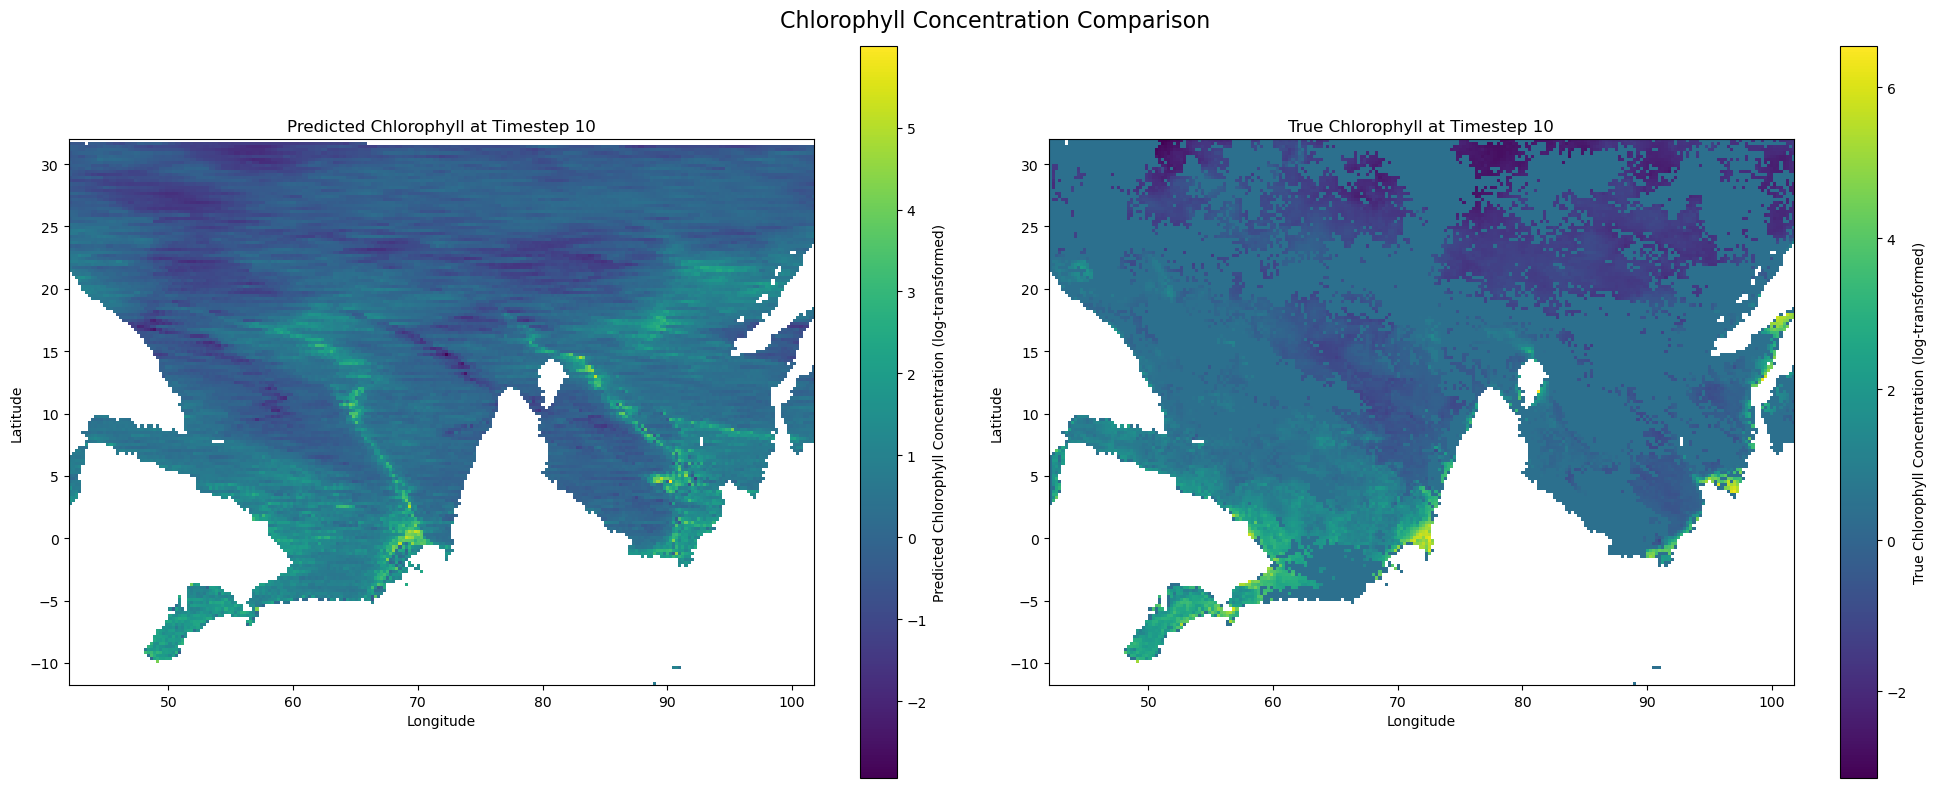

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_chlorophyll_comparison(refined_predictions, true_data, lat, lon, timestep, water_mask, title="Chlorophyll Concentration Comparison"):
    # Retrieve the refined prediction and true data for the specified timestep
    predicted_chlorophyll = refined_predictions[timestep].flatten()
    true_chlorophyll = true_data[timestep].flatten()

    # Create full NaN arrays matching the water_mask shape
    predicted_grid = np.full(water_mask.shape, np.nan)
    true_grid = np.full(water_mask.shape, np.nan)

    # Pad the arrays with NaNs if necessary
    pad_length = np.sum(water_mask) - predicted_chlorophyll.shape[0]
    if pad_length > 0:
        predicted_chlorophyll = np.pad(predicted_chlorophyll, (0, pad_length), mode='constant', constant_values=np.nan)
    
    # Assign the chlorophyll values to the water pixels
    predicted_grid[water_mask] = predicted_chlorophyll[:np.sum(water_mask)]
    true_grid[water_mask] = true_chlorophyll[:np.sum(water_mask)]

    # Reshape grids to match the lat/lon dimensions
    predicted_grid = predicted_grid.reshape(water_mask.shape)
    true_grid = true_grid.reshape(water_mask.shape)

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot predicted chlorophyll
    im1 = ax1.imshow(predicted_grid, extent=(lon.min(), lon.max(), lat.min(), lat.max()), 
                     origin='lower', cmap='viridis')
    ax1.set_title(f"Predicted Chlorophyll at Timestep {timestep}")
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    plt.colorbar(im1, ax=ax1, label='Predicted Chlorophyll Concentration (log-transformed)')

    # Plot true chlorophyll
    im2 = ax2.imshow(true_grid, extent=(lon.min(), lon.max(), lat.min(), lat.max()), 
                     origin='lower', cmap='viridis')
    ax2.set_title(f"True Chlorophyll at Timestep {timestep}")
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.colorbar(im2, ax=ax2, label='True Chlorophyll Concentration (log-transformed)')

    # Set an overall title
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

# Extract the true chlorophyll data
true_chlorophyll = data['CHL_cmes-level3']

# Example usage: visualize the comparison for timestep 10
visualize_chlorophyll_comparison(unet_predictions, true_chlorophyll, lat, lon, timestep=10, water_mask=water_mask)

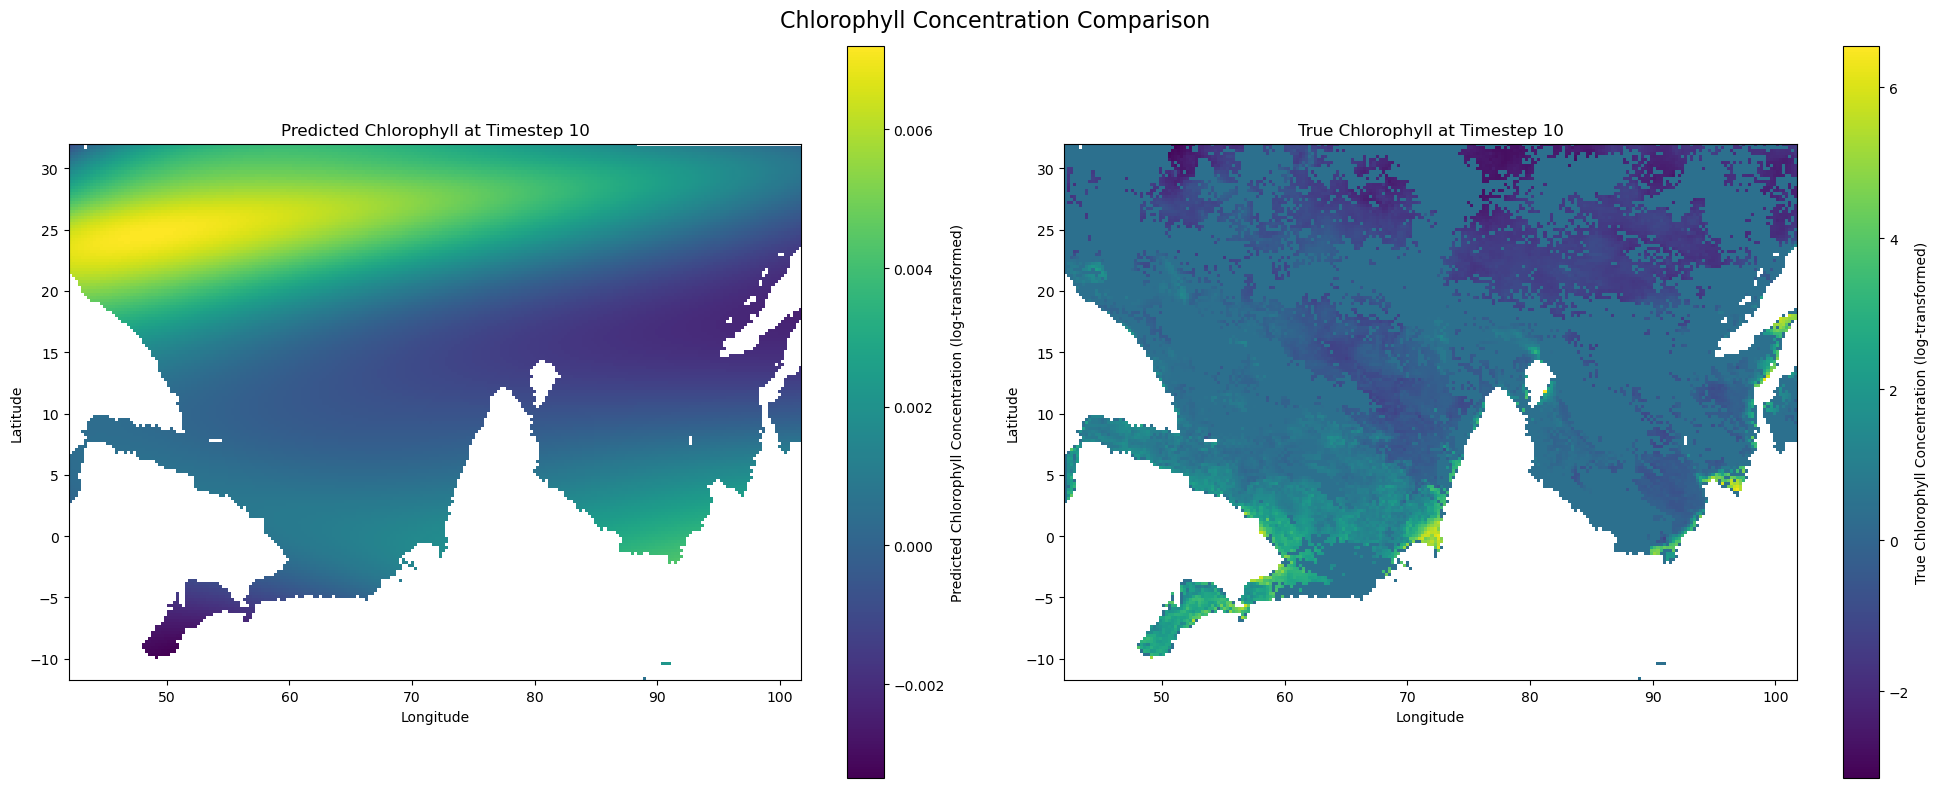

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_chlorophyll_comparison(refined_predictions, true_data, lat, lon, timestep, water_mask, title="Chlorophyll Concentration Comparison"):
    # Retrieve the refined prediction and true data for the specified timestep
    predicted_chlorophyll = refined_predictions[timestep].flatten()
    true_chlorophyll = true_data[timestep].flatten()

    # Create full NaN arrays matching the water_mask shape
    predicted_grid = np.full(water_mask.shape, np.nan)
    true_grid = np.full(water_mask.shape, np.nan)

    # Pad the arrays with NaNs if necessary
    pad_length = np.sum(water_mask) - predicted_chlorophyll.shape[0]
    if pad_length > 0:
        predicted_chlorophyll = np.pad(predicted_chlorophyll, (0, pad_length), mode='constant', constant_values=np.nan)
    
    # Assign the chlorophyll values to the water pixels
    predicted_grid[water_mask] = predicted_chlorophyll[:np.sum(water_mask)]
    true_grid[water_mask] = true_chlorophyll[:np.sum(water_mask)]

    # Reshape grids to match the lat/lon dimensions
    predicted_grid = predicted_grid.reshape(water_mask.shape)
    true_grid = true_grid.reshape(water_mask.shape)

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot predicted chlorophyll
    im1 = ax1.imshow(predicted_grid, extent=(lon.min(), lon.max(), lat.min(), lat.max()), 
                     origin='lower', cmap='viridis')
    ax1.set_title(f"Predicted Chlorophyll at Timestep {timestep}")
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    plt.colorbar(im1, ax=ax1, label='Predicted Chlorophyll Concentration (log-transformed)')

    # Plot true chlorophyll
    im2 = ax2.imshow(true_grid, extent=(lon.min(), lon.max(), lat.min(), lat.max()), 
                     origin='lower', cmap='viridis')
    ax2.set_title(f"True Chlorophyll at Timestep {timestep}")
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.colorbar(im2, ax=ax2, label='True Chlorophyll Concentration (log-transformed)')

    # Set an overall title
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

# Extract the true chlorophyll data
true_chlorophyll = data['CHL_cmes-level3']

# Example usage: visualize the comparison for timestep 10
visualize_chlorophyll_comparison(refined_predictions, true_chlorophyll, lat, lon, timestep=10, water_mask=water_mask)